In [ ]:
pip install python-dotenv

In [ ]:
import pandas as pd
import numpy as np
import cv2
from time import perf_counter
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/project/utils.py /content/utils.py

import utils

In [ ]:
!cp /content/drive/MyDrive/project/raw_tracks.csv /content/raw_tracks.csv
!cp /content/drive/MyDrive/project/mels.zip /content/mels.zip
!cp /content/drive/MyDrive/project/files.txt /content/files.txt

In [ ]:
!cp /content/drive/MyDrive/project/fma_metadata/tracks.csv /content/tracks.csv
!cp /content/drive/MyDrive/project/fma_metadata/genres.csv /content/genres.csv
!cp /content/drive/MyDrive/project/fma_metadata/features.csv /content/features.csv
!cp /content/drive/MyDrive/project/fma_metadata/echonest.csv /content/echonest.csv

In [ ]:
!unzip mels.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./mels/071/071175.png   
  inflating: ./mels/071/071216.png   
  inflating: ./mels/071/071225.png   
  inflating: ./mels/071/071228.png   
  inflating: ./mels/071/071230.png   
  inflating: ./mels/071/071231.png   
  inflating: ./mels/071/071240.png   
  inflating: ./mels/071/071241.png   
  inflating: ./mels/071/071242.png   
  inflating: ./mels/071/071243.png   
  inflating: ./mels/071/071244.png   
  inflating: ./mels/071/071245.png   
  inflating: ./mels/071/071246.png   
  inflating: ./mels/071/071247.png   
  inflating: ./mels/071/071248.png   
  inflating: ./mels/071/071249.png   
  inflating: ./mels/071/071250.png   
  inflating: ./mels/071/071251.png   
  inflating: ./mels/071/071252.png   
  inflating: ./mels/071/071253.png   
  inflating: ./mels/071/071254.png   
  inflating: ./mels/071/071255.png   
  inflating: ./mels/071/071276.png   
  inflating: ./mels/071/071303.png   
  inflating: ./mels/071/071304.png   

In [ ]:
DOWNSAMPLE_HEIGHT = 128
DOWNSAMPLE_WIDTH = 1291

In [ ]:
import ast
f = open("files.txt", "r")
data = f.read()
indices = ast.literal_eval(data)
f.close()

In [ ]:
track_data = pd.read_csv("raw_tracks.csv", index_col = 0)
data = track_data["track_genres"][np.array(indices).astype(int)]
# track_data["track_genres"]

In [ ]:
data_dict = dict()
for i in data.keys():
    data_dict[i] = ast.literal_eval(data[i])[0]["genre_title"] #data_dict contains track_ids as keys and genre_ids as values

In [ ]:
tracks = utils.load('drive/MyDrive/project/fma_metadata/tracks.csv')

In [ ]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train_initial = tracks.loc[small & train, ('track', 'genre_top')]
y_test_initial = tracks.loc[small & test, ('track', 'genre_top')]
y_val_initial = tracks.loc[small & val, ('track', 'genre_top')]

y_train_initial = y_train_initial.to_frame()
y_test_initial = y_test_initial.to_frame()
y_val_initial = y_val_initial.to_frame()

genres = ('Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock')
genres_dic = dict()
cnt = 0
for i in genres:
  genres_dic[i] = cnt
  cnt += 1

In [ ]:
y_train_np = y_train_initial.to_numpy()
y_test_np = y_test_initial.to_numpy()
y_val_np = y_val_initial.to_numpy()
y_train_np[0,0]

'Hip-Hop'

In [ ]:
x_train = np.zeros((6397, DOWNSAMPLE_HEIGHT, DOWNSAMPLE_WIDTH))
x_test = np.zeros((800 , DOWNSAMPLE_HEIGHT, DOWNSAMPLE_WIDTH))
x_val = np.zeros((800 , DOWNSAMPLE_HEIGHT, DOWNSAMPLE_WIDTH))

y_train = np.zeros(6397, dtype = int)
y_test = np.zeros(800, dtype = int)
y_val = np.zeros(800, dtype = int)

i1, i2, i3, count = 0, 0, 0, 0
for i in data_dict:
    file = "{:06d}".format(i)
    dir = file[:3]
    track_id = int(file)
    img = cv2.imread(f"/content/mels/{dir}/{file}.png")
    img = cv2.resize(img, (DOWNSAMPLE_WIDTH, DOWNSAMPLE_HEIGHT), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    if track_id in y_train_initial.index:
      x_train[i1] = img
      y_train[i1] = genres_dic[y_train_np[i1,0]]
      i1 += 1
      count += 1
    elif track_id in y_test_initial.index:
      x_test[i2] = img
      y_test[i2] = genres_dic[y_test_np[i2,0]]
      i2 += 1
      count += 1
    elif track_id in y_val_initial.index:
      x_val[i3] = img
      y_val[i3] = genres_dic[y_val_np[i3,0]]
      i3 += 1
      count += 1

In [ ]:
y_train.shape, y_test.shape, y_val.shape

((6397,), (800,), (800,))

In [ ]:
np.unique(x_train, axis = 0).shape

In [ ]:
i1, i2, i3

(6397, 800, 800)

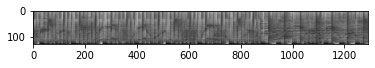

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_train[1234], cmap='gray')
# print(img_datas[3].shape)

In [ ]:
# img_datas = normalize(img_datas)
# print(img_datas.shape)

# tracks = utils.load('tracks.csv')
# genres = utils.load('genres.csv')
# features = utils.load('features.csv')
# echonest = utils.load('echonest.csv')

# tracks.shape, genres.shape, features.shape, echonest.shape

Logistic Regression

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(random_state=0, multi_class='multinomial', n_jobs=-1, max_iter=140 ).fit(x_train.reshape(6397, -1), y_train)

In [ ]:
# clf.predict(x_train.reshape(6397, -1)[:2, :])
# clf.predict_proba(x_train.reshape(6397, -1)[:2, :])
clf.score(x_test.reshape(800, -1), y_test)


0.28125

In [ ]:
clf.score(x_train.reshape(6397, -1), y_train)

0.7087697358136626

In [ ]:
def sigmoid_func(x):
    res = 1 / (1 + np.exp(-x))
    return res

In [ ]:
def propagate(w, b, data, real_label):
    num_data = data.shape[0]
    predicted = sigmoid_func(np.dot(w.T, data) + b)
    print(predicted.shape, real_label.shape)
    cost = (-1 / num_data) * np.sum(real_label * np.log(predicted) + (1-real_label) * np.log(1-predicted))
    dw = 1/num_data * np.dot(data, (predicted-real_label).T)
    db = 1/num_data * np.sum(predicted-real_label)

    return cost, dw, db

In [ ]:
def optimize_params(w, b, x_data, y_data, num_iterations, alpha):
    cost_arr = [] 
    for i in range(num_iterations):
        cost, dw, db = propagate(w, b, x_data, y_data)
        w = w - alpha * dw
        b = b - alpha * db
        if not i % 100:
            cost_arr.append(cost)
    
    return cost_arr, (w, b), (dw, db)

In [ ]:
def predict(w, b, test_data):
    num_data = test_data.shape[1]
    num_features = test_data.shape[0]
    pred_array = np.zeros((1, num_data))    
    w = w.reshape(num_features, 1)
    pred = sigmoid_func(np.dot(w.T, test_data) + b)

    for i in range(pred.shape[1]):
        pred_array[:, i] = (pred[:, i] > 0.5) * 1
        
    return pred_array

In [ ]:
w = np.zeros(x_train.reshape(6397, -1).shape[0])
b = 0
optimize_params(w, b, x_train.reshape(6397, -1), y_train, 2000, 0.5)

(41280,) (6397,)


ValueError: ignored

KNN

In [ ]:
import math
from time import perf_counter
def test(train_x, train_y, test_x, test_y, k):
  start_time = perf_counter()
  correct = [0] * 11
  for i in range(test_x.shape[0]):  
    distances = np.zeros(train_x.shape[0])
    tot = 0
    for j in range(train_x.shape[0]):
      distances[j] = math.sqrt(np.sum(np.power((test_x[i]-train_x[j]), 2)))
    distances = np.argsort(distances)
    predict = [0] * 11
    for q in range(11):
        predict[q] = np.bincount(train_y[distances[0:2*q+3]]).argmax()
        correct[q] += int(predict[q] == test_y[i])    
    if not i%8:
        print("\r{:3d}% (Time elapsed: {:3d}s)".format(i//8, int((perf_counter()-start_time)//1)), end = "")
  acc = [0] * 11
  print()
  for q in range(11):
      acc[q]  = (correct[q]/test_x.shape[0])*100 
  return acc

In [ ]:
def test2(train_x, train_y, test_x, test_y, k):
  start_time = perf_counter()
  correct = [0] * 11
  for i in range(test_x.shape[0]):  
    distances = np.zeros(train_x.shape[0])
    tot = 0
    for j in range(train_x.shape[0]):
      distances[j] = np.sum(np.abs((test_x[i]-train_x[j])))
    distances = np.argsort(distances)
    predict = [0] * 11
    for q in range(11):
        predict[q] = np.bincount(train_y[distances[0:2*q+3]]).argmax()
        correct[q] += int(predict[q] == test_y[i])    
    if not i%8:
        print("\r{:3d}% (Time elapsed: {:3d}s)".format(i//8, int((perf_counter()-start_time)//1)), end = "")
  acc = [0] * 11
  print()
  for q in range(11):
      acc[q]  = (correct[q]/test_x.shape[0])*100 
  return acc

In [ ]:
x_train /= 255
x_test /= 255
x_val /= 255

In [ ]:
#euclidean_arr = test(x_train.reshape(6397, -1), y_train, x_test.reshape(800, -1), y_test, 9)
#print("\n", euclidean_arr)
manhattan_arr = test2(x_train.reshape(6397, -1), y_train, x_test.reshape(800, -1), y_test, 9)
print("\n", manhattan_arr) 

 99% (Time elapsed: 3351s)

 [20.25, 21.75, 23.125, 22.25, 23.125, 22.75, 23.125, 23.25, 23.75, 22.5, 21.625]


In [ ]:
print("Euclidean Accuracy: 21.375, 20.875, 24.250, 23.375, 23.000, 23.750, 24.000, 24.500, 23.625, 23.375, 23.750")
print("k_val:                   3,      5,      7,      9,     11,     13,     15,     17,     19,     21,     23")
print("Manhattan Accuracy: 21.500, 22.375, 24.125, 24.250, 24.500, 24.125, 23.375, 23.375, 22.875, 23.250, 24.250")

Euclidean Accuracy: 21.375, 20.875, 24.250, 23.375, 23.000, 23.750, 24.000, 24.500, 23.625, 23.375, 23.750
k_val:                   3,      5,      7,      9,     11,     13,     15,     17,     19,     21,     23
Manhattan Accuracy: 21.500, 22.375, 24.125, 24.250, 24.500, 24.125, 23.375, 23.375, 22.875, 23.250, 24.250
